Un club del juego de Go recopiló los resultados de varias partidas entre diferentes jugadores, al-
macenados en el archivo partidas_entrenamiento.txt, con el objetivo de predecir el resultado de

partidas futuras, ejemplos de las cuales se encuentran en el archivo partidas_prueba.txt. Los ar-
chivos partidas_entrenamiento.txt y partidas_prueba.txt5

contienen 3 columnas: la primera
corresponde al identificador del jugador A, la segunda al identificador del jugador B y la tercera es
el resultado de la partida (1 si ganó el jugador A o 0 si ganó el jugador B). En el club hay un total
de D jugadores, por lo que cada identificador es un número entero entre 1 y D. La predicción del
resultado de un juego se puede plantear como un problema de clasificación: dados 2 jugadores (A y
B) se requiere predecir si A ganó (y = 1) o si fue B (y = 0). Realice los siguientes ejercicios:

In [136]:
import pandas as pd

In [137]:
#Extracción de datos de juegos

column_names = [ "player_A", "player_B", "winner"]

games_train = pd.read_csv("/Users/Leon/Documents/Data GH/Aprendizaje automático /T2/regl_data/juegos_entrenamiento.txt", sep=" ", header=None,names=column_names)
games_test = pd.read_csv("/Users/Leon/Documents/Data GH/Aprendizaje automático /T2/regl_data/juegos_validacion.txt", sep=" ", header=None,names=column_names)

En go existe una ventaja estrategica al empezar el juego, en partidas oficiales al jugador el jugador negro (quien empieza) tiene una ventaja estratigica al tener la posibilidad de marcar el ritmo del juego. Para compensar esto el jugador de blancas (el segundo en tirar) recibe 7.5 o 6.5 puntos extras al final de la partida.  Para terminos de este ejercicio supondremos que el los indicadores de ganar o perder ya cuentan con este 'handicap' por lo que el orden del jugador 'A' o 'B' es indistinto.

<Axes: xlabel='winner'>

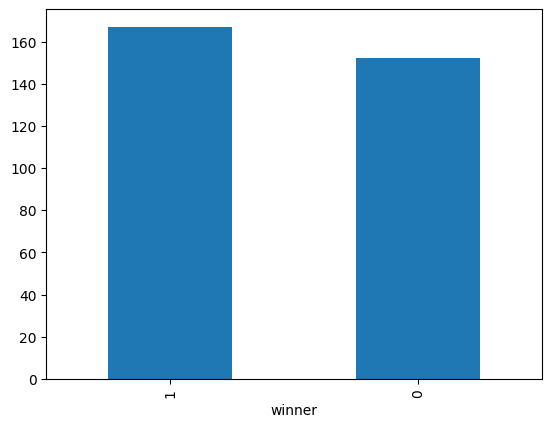

In [138]:
#Veremos que tan balanceadas estan las clases
games_train["winner"].value_counts().plot(kind="bar")

De primera instancia parecen estar equilibradas, pero lo que nos esta diciendo es que hay un poco más de partidas donde gana el jugador 'A' asi que tendremos que descomponer para ver la distribución de cada jugador

In [139]:
# Vemos con cuantos jugadores distintos contamos 
import numpy as np

totalplayers=np.union1d(np.unique(games_train["player_A"].values), np.unique(games_train["player_B"].values))
totalplayers


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142])

Parece que tenemos partidas de los 142 jugadores listados, ahora veremos si tenemos al menos una victoria y una derrota por cada jugador 


In [140]:


total = []



for numero in totalplayers:
    victorias_A = ((games_train['winner'] == 1) & (games_train['player_A'] == numero)).sum()
    victorias_B = ((games_train['winner'] == 0) & (games_train['player_B'] == numero)).sum()
    total_vic = victorias_A + victorias_B

    derrotas_A = ((games_train['winner'] == 0) & (games_train['player_A'] == numero)).sum()
    derrotas_B = ((games_train['winner'] == 1) & (games_train['player_B'] == numero)).sum()
    total_der = derrotas_A + derrotas_B

    total.append({'jugador': numero, 'victorias': total_vic,'derrotas': total_der})


conteo=pd.DataFrame(total)


In [141]:
conteo

,jugador,victorias,derrotas
0,1,4,0
1,2,0,2
2,3,2,0
3,4,3,17
4,5,2,1
...,...,...,...
137,138,5,2
138,139,2,4
139,140,3,0
140,141,3,0


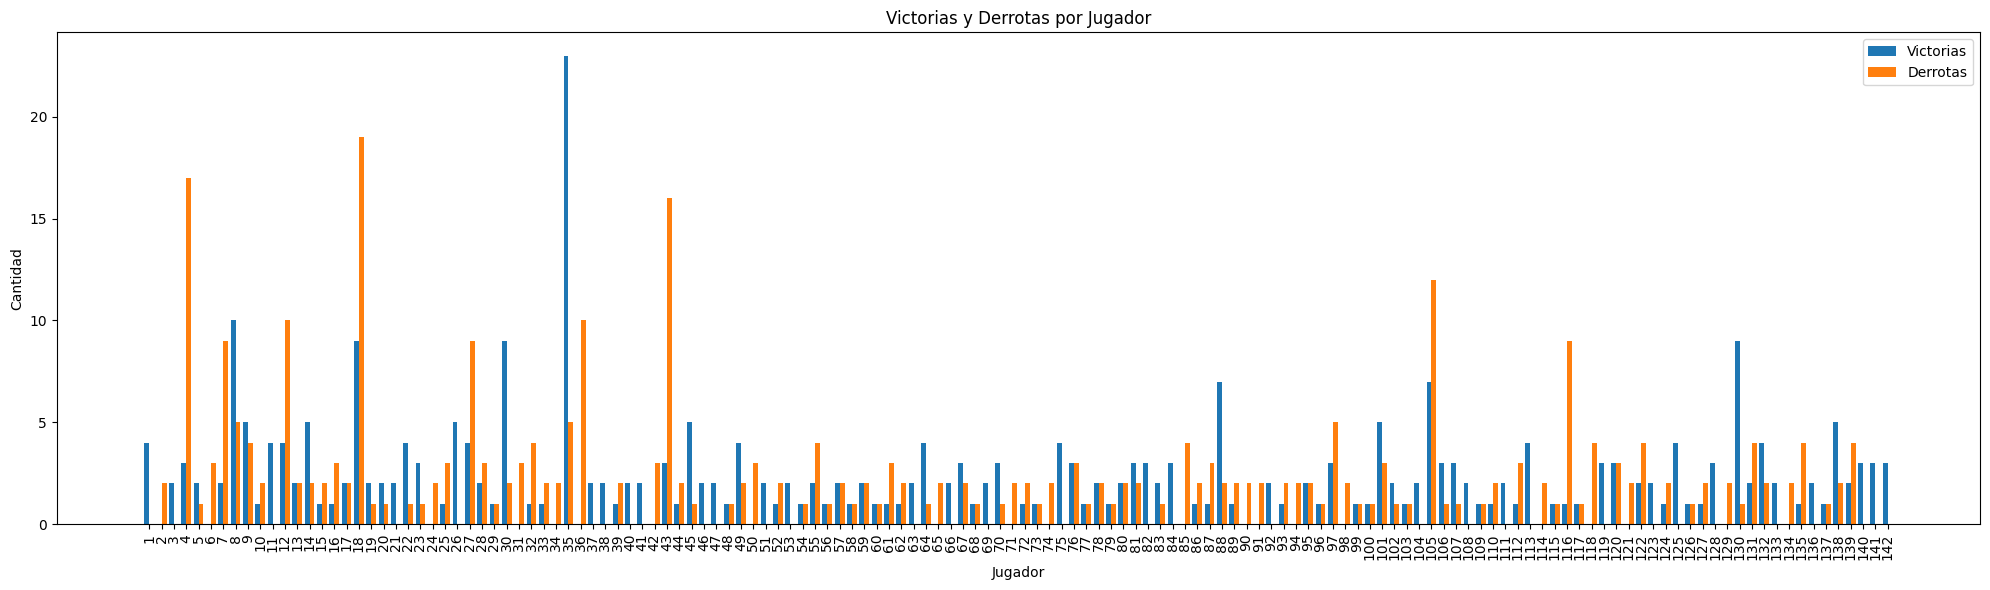

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama df y tiene columnas A, B, C
df = conteo.sort_values(by='jugador')  # Ordenar por número de jugador

# Crear gráfico
plt.figure(figsize=(20,6))
x = range(len(df))
plt.bar(x, df['victorias'], width=0.4, label='Victorias', align='center')
plt.bar([i + 0.4 for i in x], df['derrotas'], width=0.4, label='Derrotas', align='center')

# Etiquetas y formato
plt.xticks([i + 0.2 for i in x], df['jugador'], rotation=90)
plt.xlabel('Jugador')
plt.ylabel('Cantidad')
plt.title('Victorias y Derrotas por Jugador')
plt.legend()
plt.tight_layout()
plt.show()


Convertimos a numpy:

In [143]:
import numpy as np


games_train_np = games_train.to_numpy()
games_test_np = games_test.to_numpy()

X_train = games_train_np[:, :-1]
y_train = games_train_np[:, -1]


X_test = games_test_np[:, :-1]
y_test = games_test_np[:, -1]

## Entrenaremos un clasificador bayesiano ingenuo para distribución de Bernoulli
Definimos una función para obtener la probabilidad de 0 o 1 dada una distribución de Bernoulli con parámetro $q$.

In [144]:
def bernoulli(x, q):
  """
  Distribución de bernoulli
  """
  return q**x * (1.0 - q)**(1.0 - x)

## Tomamos la clase vista en clase 

In [145]:
class BernoulliNB:
  def fit(self, X, y):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    n = X.shape[0]

    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))
    for i,c in enumerate(self.clases):
      Xc = X[y == c]
      nc = Xc.shape[0]

      cuentas = np.count_nonzero(Xc, axis = 0)
      self.qa[i, :] =  cuentas / nc
      self.qc[i] = nc / n


  def predict_proba(self, X):
        """
        Calcula probabilidades a posteriori normalizadas
        """
        eps = 1e-10
        log_prop = np.zeros((X.shape[0], self.n_clases))

        for i in range(self.n_clases):
            log_probs = X * np.log(self.qa[i, :] + eps) + (1 - X) * np.log(1 - self.qa[i, :] + eps)
            log_prop[:, i] = np.sum(log_probs, axis=1) + np.log(self.qc[i] + eps)

        # Normalizamos (log-softmax)
        log_prop -= np.max(log_prop, axis=1, keepdims=True)
        prop = np.exp(log_prop)
        prop /= np.sum(prop, axis=1, keepdims=True)
        return prop
  def predict(self, X):
    """
    Predice clases de conjunto de datos
    """
    return np.argmax(self.predict_proba(X), axis=1)

In [146]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_bnb = bnb.predict(X_test)
p_bnb = bnb.predict_proba(X_test)

print(y_bnb)
print(p_bnb)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
[[0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.52351097]
 [0.47648903 0.

El modelo esta asignando en todas las ocaciones como resultado "1" hay dos opciones, el modelo esta desbalanceado (Lo cual ya descartamos en un principio) o no tiene suficiente información para asignar clases. Al ver plausible la opción dos, generaremos partidas sinteticas de acuerdo con los resultados que tenemos.

Usaremos la transitividad como supuesto para la creación de partidas artificiales:

Si jugador(a) le gana a jugador(b) y jugador(b) le gana a jugador(c), entonces jugador(a) le gana a jugador(c)

In [147]:

import networkx as nx

# Construimos la lista de victorias
victorias = []
for _, row in games_train.iterrows():
    if row['winner'] == 1:
        victorias.append((row['player_A'], row['player_B']))
    else:
        victorias.append((row['player_B'], row['player_A']))

# se plantea el grafo dirigido
G = nx.DiGraph()
G.add_edges_from(victorias)
closure = nx.transitive_closure(G)

# obtenemos las aristas originales y las inferidas
edges_originales = set(victorias)
edges_closure = set(closure.edges())
edges_inferidos = list(edges_closure - edges_originales)

# las guardamos en orden aleatorio
df_inferidas = pd.DataFrame(edges_inferidos, columns=['ganador', 'perdedor'])
flip = np.random.binomial(1, 0.5, size=len(df_inferidas))
df_inferidas['player_A'] = np.where(flip == 1, df_inferidas['ganador'], df_inferidas['perdedor'])
df_inferidas['player_B'] = np.where(flip == 1, df_inferidas['perdedor'], df_inferidas['ganador'])
df_inferidas['winner'] = flip
df_inferidas = df_inferidas[['player_A', 'player_B', 'winner']]

# combinamos los datos originales con los inferidos
df_completo = pd.concat([games_train, df_inferidas], ignore_index=True)

# eliminamos duplicados
df_completo = df_completo.drop_duplicates()

# Resultado final
print("Partidas originales:", len(games_train))
print("Partidas inferidas:", len(df_inferidas))
print("Total combinado:", len(df_completo))




Partidas originales: 319
Partidas inferidas: 1791
Total combinado: 2047


In [148]:

df_completo_np = df_completo.to_numpy()

X_train = df_completo_np[:, :-1]
y_train = df_completo_np[:, -1]

In [149]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_bnb = bnb.predict(X_test)
p_bnb = bnb.predict_proba(X_test)

print(y_bnb)
print(p_bnb)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
[[0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.48314607]
 [0.51685393 0.

In [ ]:

from scipy.optimize import minimize

class LogisticRegressionML:
    def fit(self, X, y):
        """
        Estima los parámetros (pesos) por máxima verosimilitud
        """
        self.clases = np.unique(y)
        if len(self.clases) != 2:
            raise ValueError("Este modelo solo soporta clasificación binaria.")
        
        n = X.shape[0]
        self.n_atr = X.shape[1]

        # Insertamos el bias (columna de unos)
        X = np.insert(X, 0, 1, axis=1)
        self.X_train = X
        self.y_train = y
        w_init = np.zeros(X.shape[1])

        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def loss(w):
            z = X @ w
            h = sigmoid(z)
            epsilon = 1e-5
            return -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

        def gradient(w):
            z = X @ w
            h = sigmoid(z)
            return X.T @ (h - y) / n

        res = minimize(fun=loss, x0=w_init, jac=gradient, method='BFGS')
        self.w = res.x

    def predict_proba(self, X):
        """
        Calcula la probabilidad de la clase positiva (label 1)
        """
        X = np.insert(X, 0, 1, axis=1)
        z = X @ self.w
        probs = 1 / (1 + np.exp(-z))
        return np.column_stack([1 - probs, probs])  # clase 0 y clase 1

    def predict(self, X):
        """
        Predice la clase (0 o 1) según el umbral 0.5
        """
        probs = self.predict_proba(X)
        return (probs[:, 1] >= 0.5).astype(int)
